<a href="https://colab.research.google.com/github/iimmuunnee/SolarX/blob/main/SolarX_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np
import os

# 1. 깃허브 저장소 복제 (SolarX)
!git clone https://github.com/iimmuunnee/SolarX

# 2. 폴더 이동
os.chdir('SolarX')
print(f">>> 현재 경로: {os.getcwd()}")
print(f">>> 파일 목록: {os.listdir()}")

# 3. 파일 바로 읽어오기
# 파일명이 길거나 달라도 키워드로 찾아서 자동으로 읽습니다.
weather_list = []
solar_df = None

print("\n>>> 파일 로드 및 분류 중...")
for filename in os.listdir():
    if not filename.endswith('.csv'): continue # csv 파일만 봄

    # 한글 깨짐 방지 로딩
    try:
        df = pd.read_csv(filename, encoding='cp949')
    except:
        df = pd.read_csv(filename, encoding='utf-8')

    # 내용 보고 분류
    if '기온(°C)' in df.columns:
        weather_list.append(df)
        print(f"날씨 데이터 확인: {filename}")
    elif '01시' in df.columns:
        solar_df = df
        print(f"발전량 데이터 확인: {filename}")

# 4. 날씨 데이터 합치기
if len(weather_list) >= 2:
    weather_df = pd.concat(weather_list, ignore_index=True)
    weather_df['일시'] = pd.to_datetime(weather_df['일시'])
    weather_df = weather_df.sort_values('일시').reset_index(drop=True)
elif len(weather_list) == 1:
    weather_df = weather_list[0]
else:
    print("Error: 날씨 데이터가 없습니다! 깃허브에 파일이 있는지 확인하세요.")

# 5. 발전량 데이터 전처리 (가로 -> 세로)
if solar_df is not None:
    solar_melted = solar_df.melt(id_vars=['날짜'],
                                value_vars=[f'{i:02d}시' for i in range(1, 25)],
                                var_name='시간_str',
                                value_name='발전량')
    solar_melted['Hour'] = solar_melted['시간_str'].str.replace('시', '').astype(int)
    solar_melted['Date'] = pd.to_datetime(solar_melted['날짜'])
    solar_melted['Hour'] = solar_melted['Hour'] - 1
    solar_melted['Datetime'] = solar_melted['Date'] + pd.to_timedelta(solar_melted['Hour'], unit='h')

    # 6. 최종 병합
    weather_df['Datetime'] = pd.to_datetime(weather_df['일시'])
    weather_selected = weather_df[['Datetime', '기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '일조(hr)', '일사(MJ/m2)', '전운량(10분위)']].copy()
    weather_selected = weather_selected.fillna(0)

    final_data = pd.merge(weather_selected, solar_melted[['Datetime', '발전량']], on='Datetime', how='inner')

    print("\n[Success] 데이터 준비 완료!")
    print(f"총 데이터 개수: {len(final_data)}개")
else:
    print("Error: 발전량 데이터가 없습니다!")

Cloning into 'SolarX'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 22 (delta 4), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (22/22), 651.67 KiB | 2.34 MiB/s, done.
Resolving deltas: 100% (4/4), done.
>>> 현재 경로: /content/SolarX
>>> 파일 목록: ['images', 'README.md', '한국동서발전(주)_동해바이오연료저장고지붕태양광발전_시간대별_발전량_20250630.csv', 'LICENSE', '기상청240630_250630(후반기).csv', 'SolarX_v1.ipynb', '.git', '기상청240101_240629(전반기).csv']

>>> 파일 로드 및 분류 중...
발전량 데이터 확인: 한국동서발전(주)_동해바이오연료저장고지붕태양광발전_시간대별_발전량_20250630.csv
날씨 데이터 확인: 기상청240630_250630(후반기).csv
날씨 데이터 확인: 기상청240101_240629(전반기).csv

[Success] 데이터 준비 완료!
총 데이터 개수: 13080개


# 데이터 전처리

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

In [3]:
# 1. 데이터 준비 (입력값 X, 정답값 y)
print(">>> 데이터 전처리 중...")

# 사용할 특징(Feature) 선택: 날씨 7개 + 과거 발전량 1개 = 총 8개
feature_cols = ['기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '일조(hr)', '일사(MJ/m2)', '전운량(10분위)', '발전량']
label_col = ['발전량']

# 데이터 정규화 Min-Max 스케일링 (0~1 사이로 압축)
# 입력(X)과 정답(y)의 스케일러를 따로 생성
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

# 입력 데이터 정규화
data_x = scaler_x.fit_transform(final_data[feature_cols])
# 정답 데이터 정규화 (나중에 그래프 그릴 때 원래 값으로 복구하기 위해 따로 둠)
data_y = scaler_y.fit_transform(final_data[label_col])

# 시계열 데이터셋 만들기 (과거 24시간 데이터를 보고 -> 다음 1시간 예측)
def create_sequences(data_x, data_y, seq_length=24):
    xs, ys = [], []
    for i in range(len(data_x) - seq_length):
        x = data_x[i:i+seq_length]
        y = data_y[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 24
X, y = create_sequences(data_x, data_y, SEQ_LENGTH)

# 텐서(Tensor)로 변환
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# 학습용(Train) / 검증용(Test) 나누기 (80% 학습, 20% 시험)
train_size = int(len(X) * 0.8)
X_train, X_test = X_tensor[:train_size], X_tensor[train_size:]
y_train, y_test = y_tensor[:train_size], y_tensor[train_size:]

print(f"학습 데이터: {len(X_train)}개, 테스트 데이터: {len(X_test)}개")

>>> 데이터 전처리 중...
학습 데이터: 10444개, 테스트 데이터: 2612개


# LSTM 모델 설계

In [4]:
# 2. LSTM 모델 설계 (입력 8개 -> 출력 1개)
class SolarLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(SolarLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM 층
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # 결과 출력 층
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # 초기 은닉 상태(h0)와 셀 상태(c0)를 0으로 초기화
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        # 마지막 시간대의 결과만 사용
        out = self.fc(out[:, -1, :])
        return out

# 모델 생성 (입력=8개, 은닉층=64개, 출력=1개)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"사용 장치: {device}")

model = SolarLSTM(input_size=8, hidden_size=64, output_size=1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

사용 장치: cpu


# 모델 학습

In [5]:
# 3. 학습 시작 (Training)
print("\n>>> 학습 시작! (Loss가 줄어드는지 확인하세요)")
num_epochs = 100
batch_size = 64

# 데이터 로더 (배치 단위로 학습)
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

loss_history = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    loss_history.append(avg_loss)

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}")


>>> 학습 시작! (Loss가 줄어드는지 확인하세요)
Epoch [10/100], Loss: 0.002989
Epoch [20/100], Loss: 0.002864
Epoch [30/100], Loss: 0.002716
Epoch [40/100], Loss: 0.002717
Epoch [50/100], Loss: 0.002642
Epoch [60/100], Loss: 0.002565
Epoch [70/100], Loss: 0.002437
Epoch [80/100], Loss: 0.002371
Epoch [90/100], Loss: 0.002215
Epoch [100/100], Loss: 0.002114


# 학습 결과 확인


>>> 예측 결과 그리는 중...


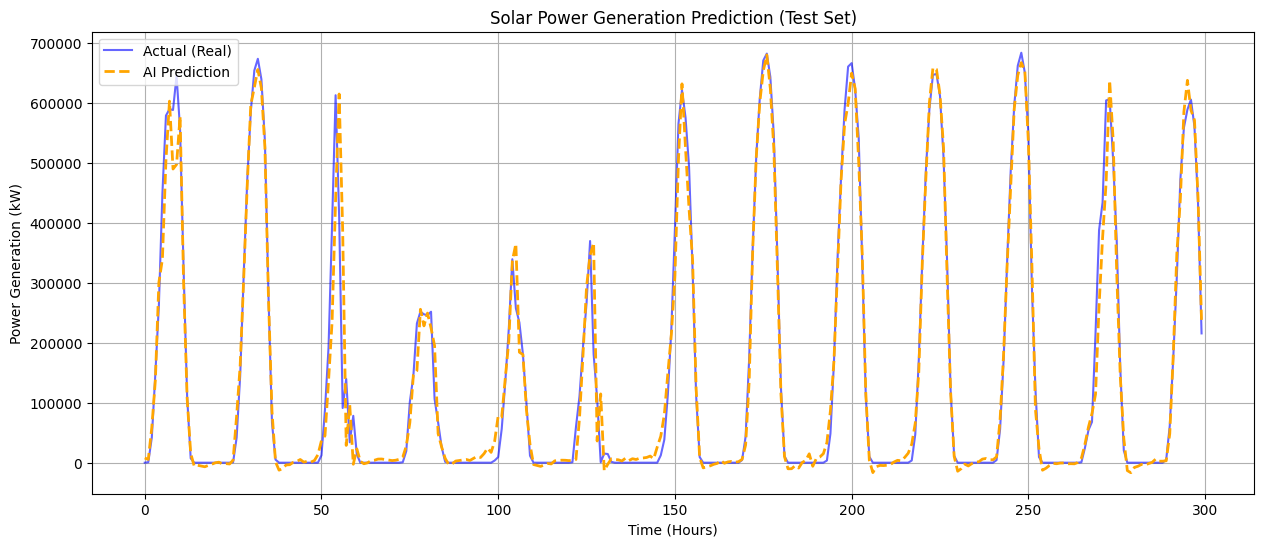


📊 모델 정확도 (R2 Score): 0.9415 (1.0에 가까울수록 완벽)


In [6]:
# 4. 결과 확인 (그래프 그리기)
print("\n>>> 예측 결과 그리는 중...")
model.eval()
with torch.no_grad():
    X_test = X_test.to(device)
    test_predict = model(X_test).cpu().numpy()
    y_test_real = y_test.numpy()

# 정규화 풀고 원본 데이터 단위로
test_predict_inv = scaler_y.inverse_transform(test_predict)
y_test_real_inv = scaler_y.inverse_transform(y_test_real)

# 그래프 그리기 (너무 길어서 앞부분 300시간=약 12일치만 확대해서 그림)
plt.figure(figsize=(15, 6))
plt.plot(y_test_real_inv[:300], label='Actual (Real)', color='blue', alpha=0.6)
plt.plot(test_predict_inv[:300], label='AI Prediction', color='orange', linestyle='--', linewidth=2)
plt.title('Solar Power Generation Prediction (Test Set)')
plt.xlabel('Time (Hours)')
plt.ylabel('Power Generation (kW)')
plt.legend()
plt.grid(True)
plt.show()

# 전체 구간에 대한 R2 Score (정확도 점수)
from sklearn.metrics import r2_score
r2 = r2_score(y_test_real_inv, test_predict_inv)
print(f"\n📊 모델 정확도 (R2 Score): {r2:.4f} (1.0에 가까울수록 완벽)")

# AI 모델 기반 태양광 발전량 예측 및 ESS 최적 제어

>>> 🔋 [Final Battle] 글로벌 3사 배터리 정밀 분석 시작...

Manufacturer              | Profit (KRW)    | Imp(%)    
------------------------------------------------------------
LG Energy Solution (NCM)  | 53,847,424     | +26.31%
Samsung SDI (NCA)         | 54,044,060     | +26.77%
Tesla In-house (4680)     | 53,457,184     | +25.39%


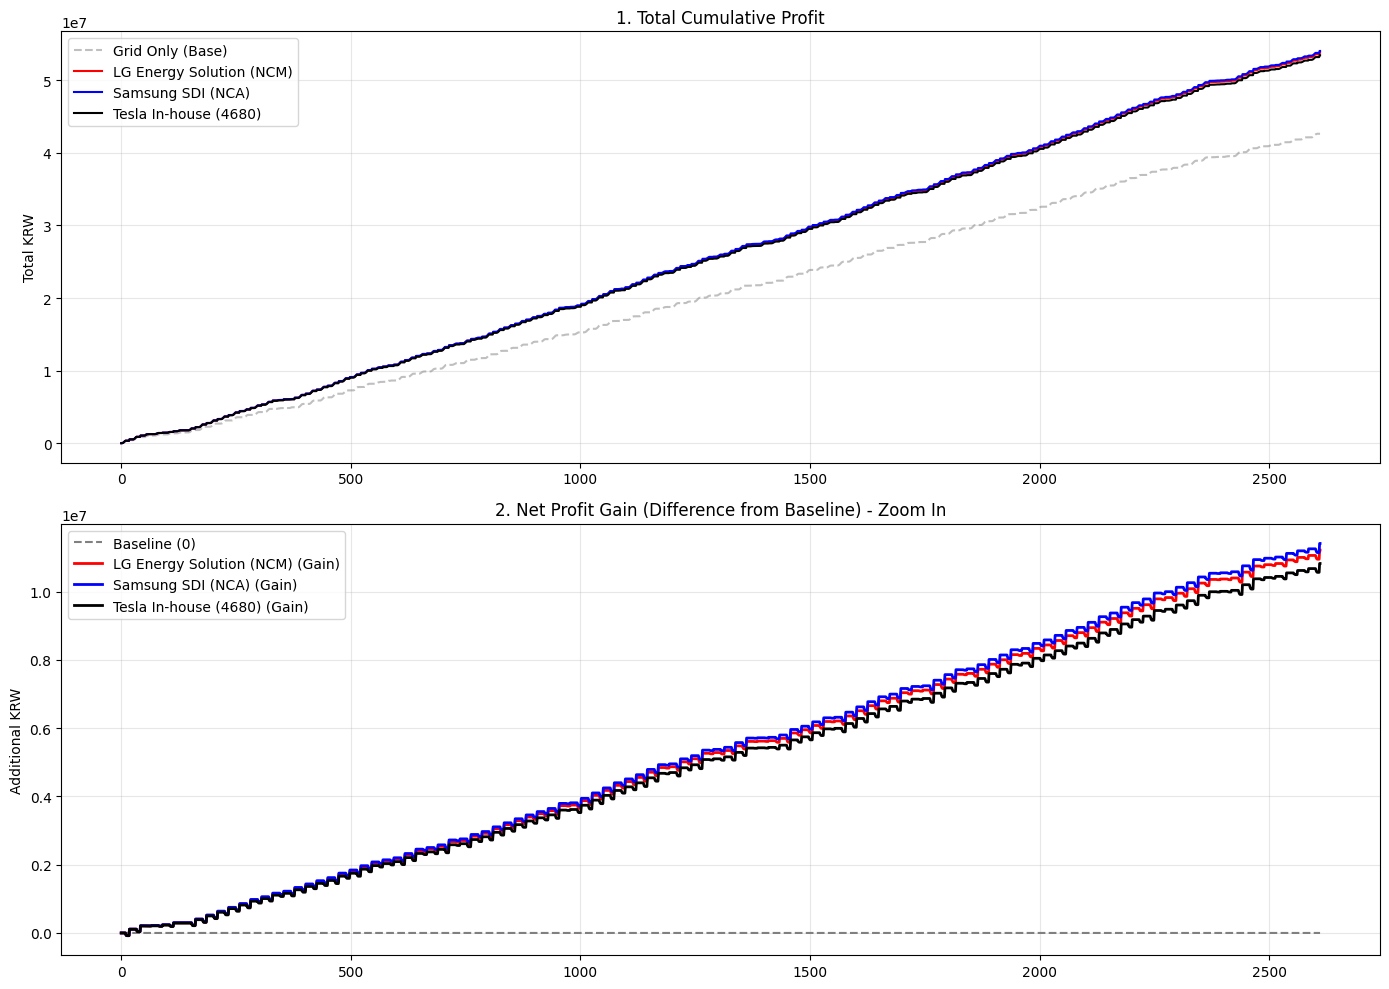


💰 [최종] 글로벌 배터리 3사 성적표 💰
0. 기존 방식 (No ESS): 42,632,416원
1. LG Energy Solution (NCM): 53,847,424원 (+26.31%)
2. Samsung SDI (NCA): 54,044,060원 (+26.77%)
3. Tesla In-house (4680): 53,457,184원 (+25.39%)

🏆 최종 우승: [Samsung SDI (NCA)]
   -> 이유: 충전 속도보다 '에너지 효율'이 수익성에 더 중요함


In [7]:
import numpy as np
import matplotlib.pyplot as plt

# 1. 데이터 준비 (단위: kW)
try:
    y_real_kw = y_test_real_inv / 1000
    predict_kw = test_predict_inv / 1000
    battery_capacity = np.max(y_real_kw) * 3
except:
    print("⚠️ 데이터 변수가 없습니다. 1단계부터 실행해주세요.")

print(f">>> 🔋 [Final Battle] 글로벌 3사 배터리 정밀 분석 시작...\n")

# 2. 범용 배터리 클래스
class UniversalBattery:
    def __init__(self, name, capacity, c_rate, eff, soc_range):
        self.name = name
        self.capacity = capacity
        self.max_power_kw = capacity * c_rate
        self.eff = eff
        self.soc_min, self.soc_max = soc_range
        self.current_kwh = capacity * self.soc_min

    def update(self, action, amount_kw):
        amount_kw = min(amount_kw, self.max_power_kw)
        actual_trade = 0

        if action == 1: # 충전
            max_storable = (self.capacity * self.soc_max) - self.current_kwh
            charge_amt = min(amount_kw, max_storable)
            self.current_kwh += charge_amt * self.eff
            actual_trade = -charge_amt

        elif action == -1: # 방전
            max_dischargeable = self.current_kwh - (self.capacity * self.soc_min)
            discharge_amt = min(max_dischargeable, self.max_power_kw)
            self.current_kwh -= discharge_amt
            grid_out = discharge_amt * self.eff
            actual_trade = grid_out

        return actual_trade

# 3. 시나리오 설정 (3사 특성)
scenarios = [
    { "name": "LG Energy Solution (NCM)", "c_rate": 2.0, "eff": 0.980, "soc": (0.05, 0.95), "color": "red" },
    { "name": "Samsung SDI (NCA)", "c_rate": 1.8, "eff": 0.985, "soc": (0.05, 0.95), "color": "blue" }, # 효율 0.5% 우위
    { "name": "Tesla In-house (4680)", "c_rate": 1.5, "eff": 0.970, "soc": (0.10, 0.90), "color": "black" }
]

prices = []
for h in range(len(predict_kw)):
    hour = h % 24
    if 18 <= hour <= 22: prices.append(200)
    elif 10 <= hour <= 16: prices.append(80)
    else: prices.append(100)

# 4. 시뮬레이션 실행
results = [] # 결과 저장용 리스트

# (1) 기준점: No ESS
profit_none = 0
history_none = []
for t in range(len(predict_kw)):
    profit_none += y_real_kw[t][0] * prices[t]
    history_none.append(profit_none)

# 그래프 설정 (2개로 나눔: 전체 수익 / 순수 개선익)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# 기준선 그리기
ax1.plot(history_none, label='Grid Only (Base)', color='gray', linestyle='--', alpha=0.5)
ax2.plot([0]*len(history_none), label='Baseline (0)', color='gray', linestyle='--')

print(f"{'Manufacturer':<25} | {'Profit (KRW)':<15} | {'Imp(%)':<10}")
print("-" * 60)

for scen in scenarios:
    ess = UniversalBattery(scen['name'], battery_capacity, scen['c_rate'], scen['eff'], scen['soc'])
    profit = 0
    history = []

    for t in range(len(predict_kw)):
        actual_gen = y_real_kw[t][0]
        predicted_gen = predict_kw[t][0]
        price = prices[t]
        hour = t % 24

        action = 0
        if 18 <= hour <= 22: action = -1
        elif 10 <= hour <= 16 and predicted_gen > 0.1: action = 1

        battery_change = ess.update(action, actual_gen)
        trade_amount = actual_gen + battery_change
        if trade_amount < 0: trade_amount = 0
        profit += trade_amount * price
        history.append(profit)

    imp = ((profit - profit_none) / profit_none) * 100

    # 결과 저장
    results.append({
        "name": scen['name'],
        "final_profit": int(profit),
        "improvement": imp
    })

    print(f"{scen['name']:<25} | {int(profit):,}     | +{imp:.2f}%")

    # 그래프 1: 전체 누적 수익
    ax1.plot(history, label=f"{scen['name']}", color=scen['color'], linewidth=1.5)

    # 그래프 2: [핵심] 순수 추가 수익 (Net Gain) -> 여기서 차이가 확 보임
    net_gain = np.array(history) - np.array(history_none)
    ax2.plot(net_gain, label=f"{scen['name']} (Gain)", color=scen['color'], linewidth=2)

# 그래프 꾸미기
ax1.set_title('1. Total Cumulative Profit')
ax1.set_ylabel('Total KRW')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.set_title('2. Net Profit Gain (Difference from Baseline) - Zoom In')
ax2.set_ylabel('Additional KRW')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5. 최종 결과 리포트 (3개 다 출력)
print(f"\n💰 [최종] 글로벌 배터리 3사 성적표 💰")
print(f"0. 기존 방식 (No ESS): {int(profit_none):,}원")
for i, res in enumerate(results):
    print(f"{i+1}. {res['name']}: {res['final_profit']:,}원 (+{res['improvement']:.2f}%)")

# 1등 찾기
winner = max(results, key=lambda x:x['final_profit'])
print(f"\n🏆 최종 우승: [{winner['name']}]")
print(f"   -> 이유: 충전 속도보다 '에너지 효율'이 수익성에 더 중요함")

>>> 🌍 [Global Scalability Test] 다양한 기후 환경에서의 로봇 스테이션 검증...

Location             | Total Gen (MW)  | Final Profit (KRW)   | Status
--------------------------------------------------------------------------------
Donghae (Base)       | 446.37          | 54,064,596       | Complete
Jeju (High Solar)    | 533.57          | 64,630,037       | Complete
Seattle (Low Solar)  | 267.82          | 32,438,748       | Complete


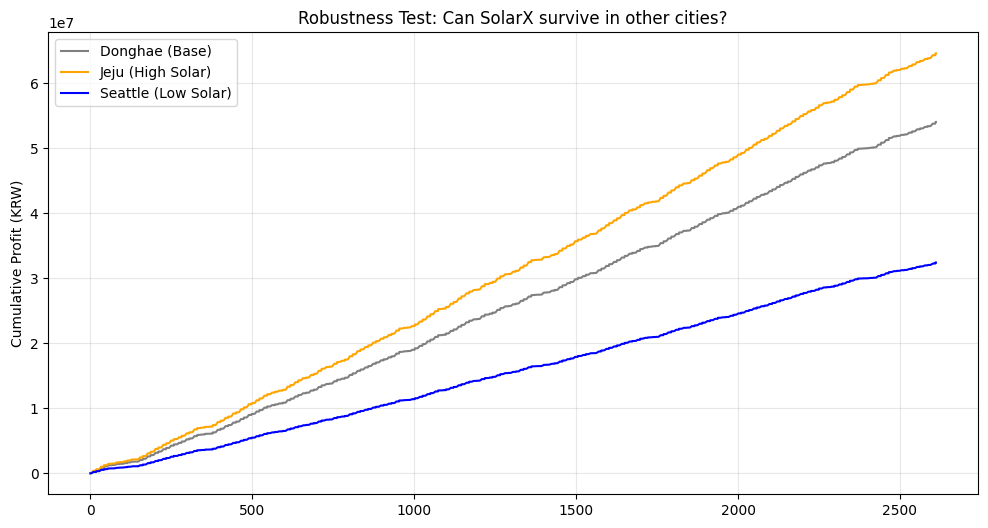

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# 1. 데이터 준비 (기존 동해 데이터 활용)
try:
    # 기존 데이터가 메모리에 있다면 가져오기
    base_gen = y_real_kw # 동해 (Baseline)
    capacity = battery_capacity # 동해 기준 용량
except:
    print("⚠️ 이전 코드를 먼저 실행하여 데이터를 로드해주세요!")

print(f">>> 🌍 [Global Scalability Test] 다양한 기후 환경에서의 로봇 스테이션 검증...\n")

# 2. 가상 환경 데이터 생성 (Synthetic Data Generation)
# (1) 제주도 (Jeju): 발전량 1.2배, 변동성(노이즈) 증가
noise = np.random.normal(0, 0.1, size=base_gen.shape) # 10% 변동성
jeju_gen = base_gen * 1.2 + (base_gen * noise)
jeju_gen = np.maximum(jeju_gen, 0) # 음수 방지

# (2) 시애틀 (Seattle): 발전량 0.6배 (흐림)
seattle_gen = base_gen * 0.6

# 3. 환경별 데이터셋 패키징
locations = [
    {"name": "Donghae (Base)", "data": base_gen, "color": "gray"},
    {"name": "Jeju (High Solar)", "data": jeju_gen, "color": "orange"},
    {"name": "Seattle (Low Solar)", "data": seattle_gen, "color": "blue"}
]

# 4. 검증용 배터리 설정 (우승 모델: Samsung SDI 적용)
# 핵심: 배터리 스펙은 똑같이 유지하고, 환경만 바꿨을 때 잘 버티는지 확인
class SamsungBattery:
    def __init__(self, capacity, c_rate=1.8, eff=0.985):
        self.capacity = capacity
        self.max_power = capacity * c_rate
        self.eff = eff
        self.soc_min, self.soc_max = 0.05, 0.95
        self.current = capacity * 0.05

    def update(self, action, amt):
        amt = min(amt, self.max_power)
        trade = 0
        if action == 1: # 충전
            storable = (self.capacity * self.soc_max) - self.current
            real_in = min(amt, storable)
            self.current += real_in * self.eff
            trade = -real_in
        elif action == -1: # 방전
            outable = self.current - (self.capacity * self.soc_min)
            real_out = min(outable, self.max_power)
            self.current -= real_out
            trade = real_out * self.eff
        return trade

# 가격표 (그대로 사용)
prices = []
for h in range(len(base_gen)):
    hour = h % 24
    if 18 <= hour <= 22: prices.append(200)
    elif 10 <= hour <= 16: prices.append(80)
    else: prices.append(100)

# 5. 시뮬레이션 실행
plt.figure(figsize=(12, 6))

print(f"{'Location':<20} | {'Total Gen (MW)':<15} | {'Final Profit (KRW)':<20} | {'Status'}")
print("-" * 80)

for loc in locations:
    # 각 지역마다 새 배터리 설치
    ess = SamsungBattery(capacity)
    profit = 0
    history = []
    data = loc['data']

    for t in range(len(data)):
        gen = data[t][0]
        price = prices[t]
        hour = t % 24

        # AI 전략 (동해에서 배운 로직 그대로 적용)
        action = 0
        if 18 <= hour <= 22: action = -1
        elif 10 <= hour <= 16: action = 1 # 예측값 대신 단순 시간 제어로 테스트 (강건성 확인)

        batt_change = ess.update(action, gen)
        trade = gen + batt_change
        if trade < 0: trade = 0

        profit += trade * price
        history.append(profit)

    total_gen_mw = np.sum(data) / 1000
    print(f"{loc['name']:<20} | {total_gen_mw:<15.2f} | {int(profit):,}       | Complete")
    plt.plot(history, label=f"{loc['name']}", color=loc['color'])

plt.title('Robustness Test: Can SolarX survive in other cities?')
plt.ylabel('Cumulative Profit (KRW)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()